В этом проекте мы будем предсказывать, сделает ли клиент банка вклад или нет. Мы будем рассматривать следующие признаки:
##### Категориальные:
* Работа
* Семейное положение
* Образование
* Есть ли дефолт по кредиту (default)
* Есть ли жилищный кредит (housing)
* Есть ли кредит
* Способ установления контакта
* Месяц установления контакта
* Исход прошлой кампании (poutcome)
##### Численные 
* Возраст
* Среднегодовой баланс в евро (balance)
* День установления контакта
* Количество контактов во время текущей кампании (campaign)
* Количество прошедших дней с последнего контакта, -1 означает, что с клиентом не связывались (pdays)
* Количество контактов во время прошлой кампании (previous)

### Data Extraction

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('bank.csv',sep =';')
cat_features = ['job','marital','education','default','housing','loan','contact','month','poutcome']
num_features = ['age','balance','day','campaign','pdays','previous','duration']
target_feature = ['y']
all_features = cat_features + num_features

Очищаем данные от возможных пропусков

In [3]:
data.replace(r'^\s*$', np.nan, regex=True,inplace=True)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [8]:
data_encoded = data.copy()
data_encoded[target_feature] = data_encoded[target_feature].apply(lambda x: x == 'yes')
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   bool  
dtypes: bool(1), int64(7), object(9)
memory usage: 569.7+ KB


### Data Visualisation 

Построим гистограммы для численных признаков и круговые диаграммы для категорианльных. Также мы построим корелляционную матрицу признаков  

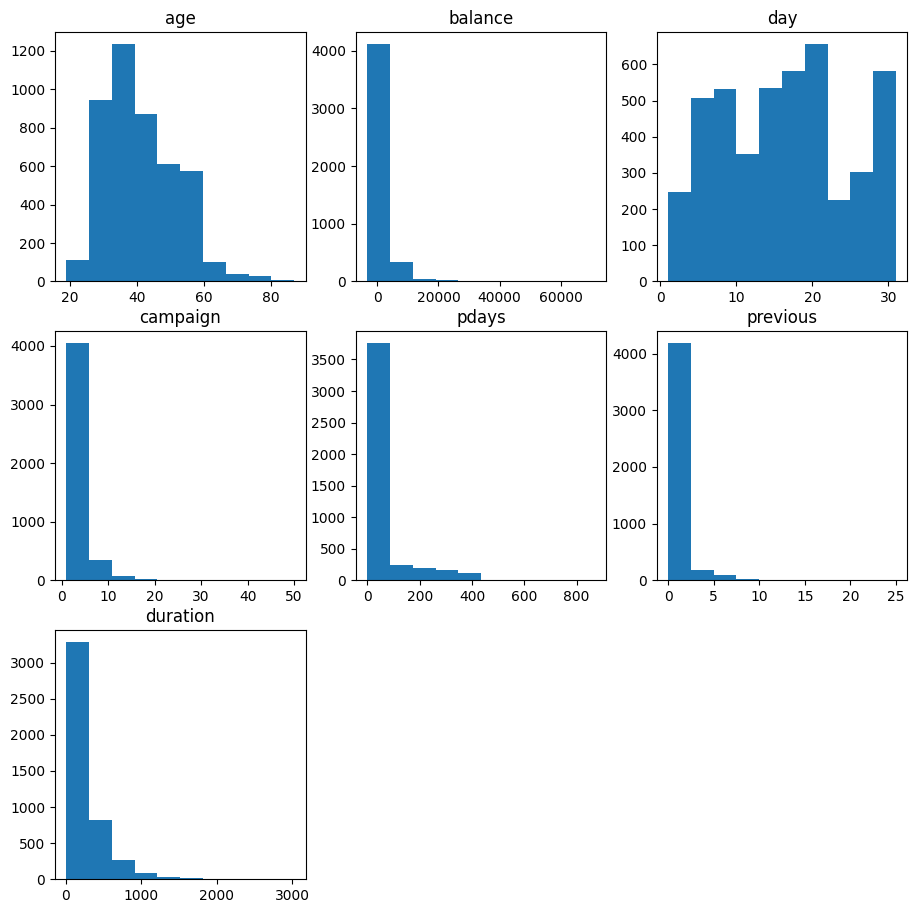

In [5]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(11)
fig.set_figwidth(11)
j = 0
for i,num in enumerate(num_features):
    axs[i  // 3 ,i % 3].hist(data_encoded[num])
    axs[i // 3,i % 3].set_title(f'{num}')
for i in range(len(num_features), 9):
    fig.delaxes(axs[i // 3, i % 3])

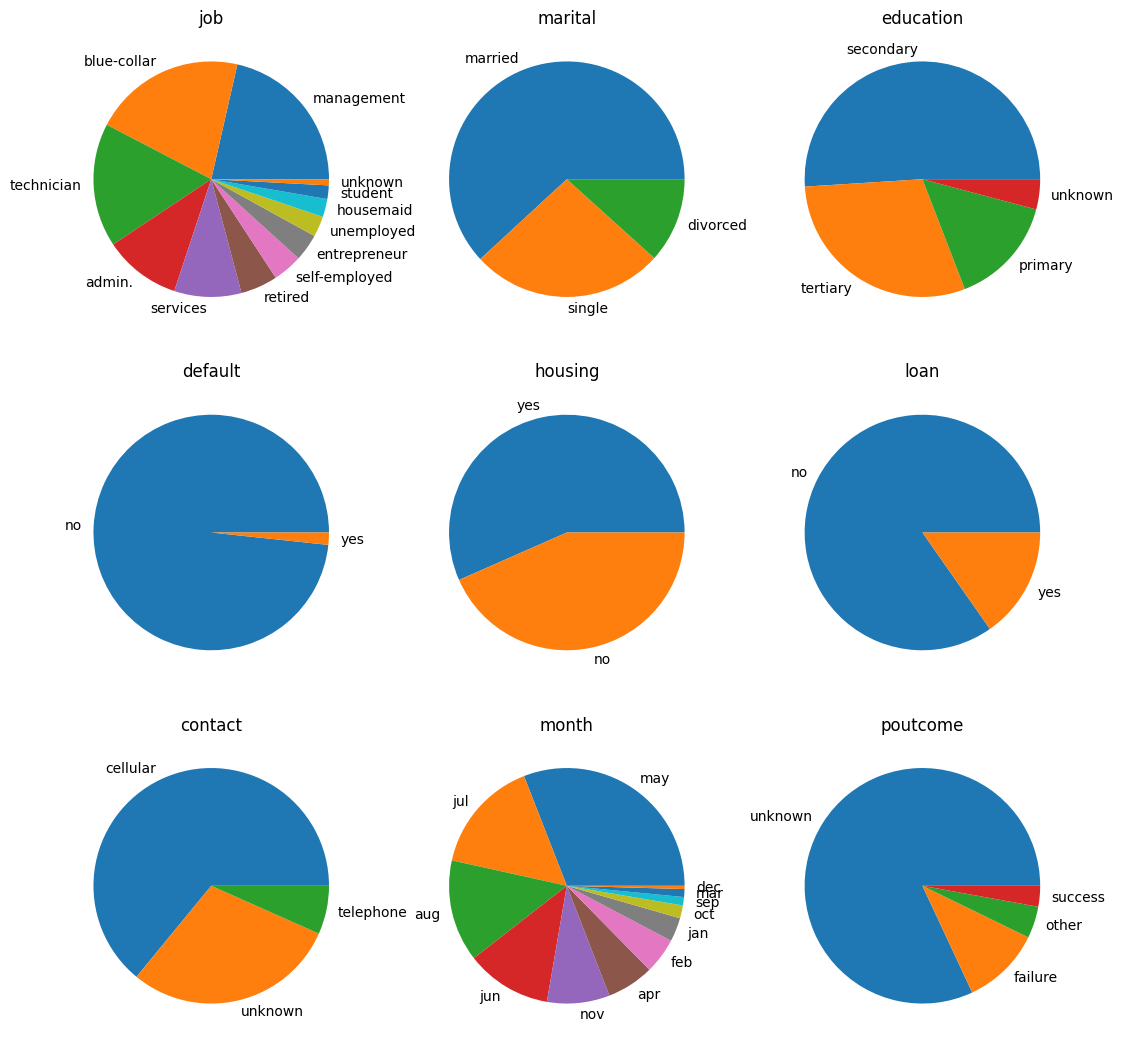

In [6]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(13)
fig.set_figwidth(13)
j = 0
for i,cat in enumerate(cat_features):
    axs[i // 3, i % 3].pie(data_encoded[cat].value_counts(),labels = data_encoded[cat].value_counts().index)
    axs[i // 3,i % 3].set_title(f'{cat}')

In [9]:
data_encoded[num_features+target_feature].corr().style.background_gradient(cmap='coolwarm')

,age,balance,day,campaign,pdays,previous,duration,y
age,1.000000,0.083820,-0.017853,-0.005148,-0.008894,-0.003511,-0.002367,0.045092
balance,0.083820,1.000000,-0.008677,-0.009976,0.009437,0.026196,-0.015950,0.017905
day,-0.017853,-0.008677,1.000000,0.160706,-0.094352,-0.059114,-0.024629,-0.011244
campaign,-0.005148,-0.009976,0.160706,1.000000,-0.093137,-0.067833,-0.068382,-0.061147
pdays,-0.008894,0.009437,-0.094352,-0.093137,1.000000,0.577562,0.010380,0.104087
previous,-0.003511,0.026196,-0.059114,-0.067833,0.577562,1.000000,0.018080,0.116714
duration,-0.002367,-0.015950,-0.024629,-0.068382,0.010380,0.018080,1.000000,0.401118
y,0.045092,0.017905,-0.011244,-0.061147,0.104087,0.116714,0.401118,1.000000


Как видно, целевая переменная сильно скореллирована только с длительностью разговора. Для оценки силы ассоциации между категориальными признаками и целевой переменной, воспользуемся тестом Крамера V.

In [10]:
def cramers_v(chi2, n, k):
    return np.sqrt(chi2 / (n * (k - 1)))

def calculate_cramers_v(data, feature, target):
    
    contingency_table = pd.crosstab(data[feature], data[target])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum() 
    k = min(contingency_table.shape) 
    cramer_v = cramers_v(chi2_stat, n, k)
    
    return cramer_v, p_value
for feature in cat_features:
    cramer_v_value, p_value = calculate_cramers_v(data_encoded, feature, 'y')
    print(f"Feature: {feature}, Cramér's V: {cramer_v_value}, p-value: {p_value}")

Feature: job, Cramér's V: 0.1235294259608967, p-value: 1.901391096662705e-10
Feature: marital, Cramér's V: 0.06487879626537206, p-value: 7.373535401823763e-05
Feature: education, Cramér's V: 0.058053243367139414, p-value: 0.001625240003630989
Feature: default, Cramér's V: 0.0, p-value: 1.0
Feature: housing, Cramér's V: 0.10398457120534615, p-value: 2.7146998959323014e-12
Feature: loan, Cramér's V: 0.06955449857446128, p-value: 2.9148288298428256e-06
Feature: contact, Cramér's V: 0.1394128177534659, p-value: 8.30430129641147e-20
Feature: month, Cramér's V: 0.23538927243938482, p-value: 2.195354833570811e-47
Feature: poutcome, Cramér's V: 0.29252933209523646, p-value: 1.5398831095860172e-83


Из категориальных признаков, наибольшее влияние на текущее решение оказывает исход предыдущего решения. Также влияет месяц последнего контакта. Мы можем попробовать добавить новые признаки. Например, можно ожидать, что люди моложе 30 лет с большим балансом более охотно будут делать вклад. Люди без кредитов тоже могут с большей вероятностью принять предложение банка.    

In [11]:
data_encoded["age_balance"] = (data_encoded["balance"] >= 5000) & (data_encoded["age"] <= 35) 
data_encoded["no_loans"] = (data_encoded["loan"] == 'no') & (data_encoded["housing"] == 'no')
for feature in ["age_balance","no_loans"]:
    cramer_v_value, p_value = calculate_cramers_v(data_encoded, feature, 'y')
    print(f"Feature: {feature}, Cramer's V: {cramer_v_value}, p-value: {p_value}")

Feature: age_balance, Cramer's V: 0.009799993988560044, p-value: 0.5099370351938608
Feature: no_loans, Cramer's V: 0.12797531872412246, p-value: 7.641439308719199e-18


Однако видим, что ни один из добавленных признаков почти не оказывает влияния на целевую переменную.

Text(0.5, 1.0, 'target')

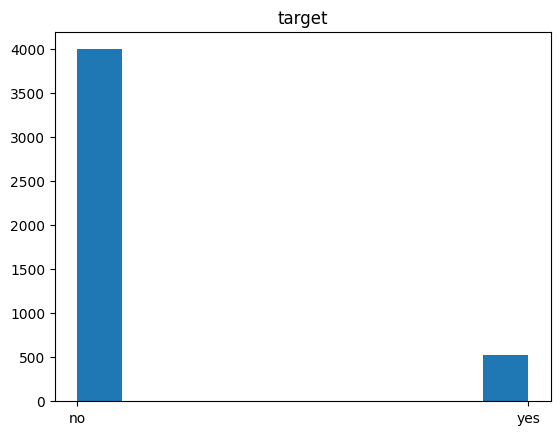

In [12]:
plt.hist(data[target_feature])
plt.title('target')

Также видим, что классы несбалансированны, мы будем это учитывать при классификации. 

### Data Preparation

In [13]:
from sklearn.compose import ColumnTransformer

In [14]:
y = data_encoded[target_feature]
X_train, X_test, y_train, y_test = train_test_split(data_encoded,np.ravel(y),train_size = 0.8, stratify = y,random_state = 13)

Разделим данные на тестовые и тренировочные и создадим preprocessor, который будет стандартизировать численные признаки и кодировать категориальные с помощью OneHotEncoder. 

In [15]:
preprocessor = ColumnTransformer( transformers=[ ('num', StandardScaler(), num_features),  ('cat', OneHotEncoder(), cat_features)])

### Classification 

In [16]:
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import accuracy_score, classification_report

##### Simple Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression

При классификации с помощью регресии, добавим class_weight = 'balanced' для борьбы с несбалансированными классами.

In [18]:
log_regCV = make_pipeline(preprocessor,LogisticRegressionCV(class_weight = 'balanced',cv=StratifiedKFold(5),scoring='roc_auc',refit=True))
log_regCV.fit(X_train,y_train)
print(classification_report(log_regCV.predict(X_test),y_test,target_names = ['no','yes']))

              precision    recall  f1-score   support

          no       0.84      0.97      0.90       693
         yes       0.83      0.41      0.54       212

    accuracy                           0.84       905
   macro avg       0.83      0.69      0.72       905
weighted avg       0.84      0.84      0.82       905



Получаем, что при такой классификации модель плохо предсказывает, в каких случаях будет сделан вклад из-за большого количества ложноотрицательных исходов. Посмотрим, какие признаки оказывают наибольшее влияние на предсказание модели:

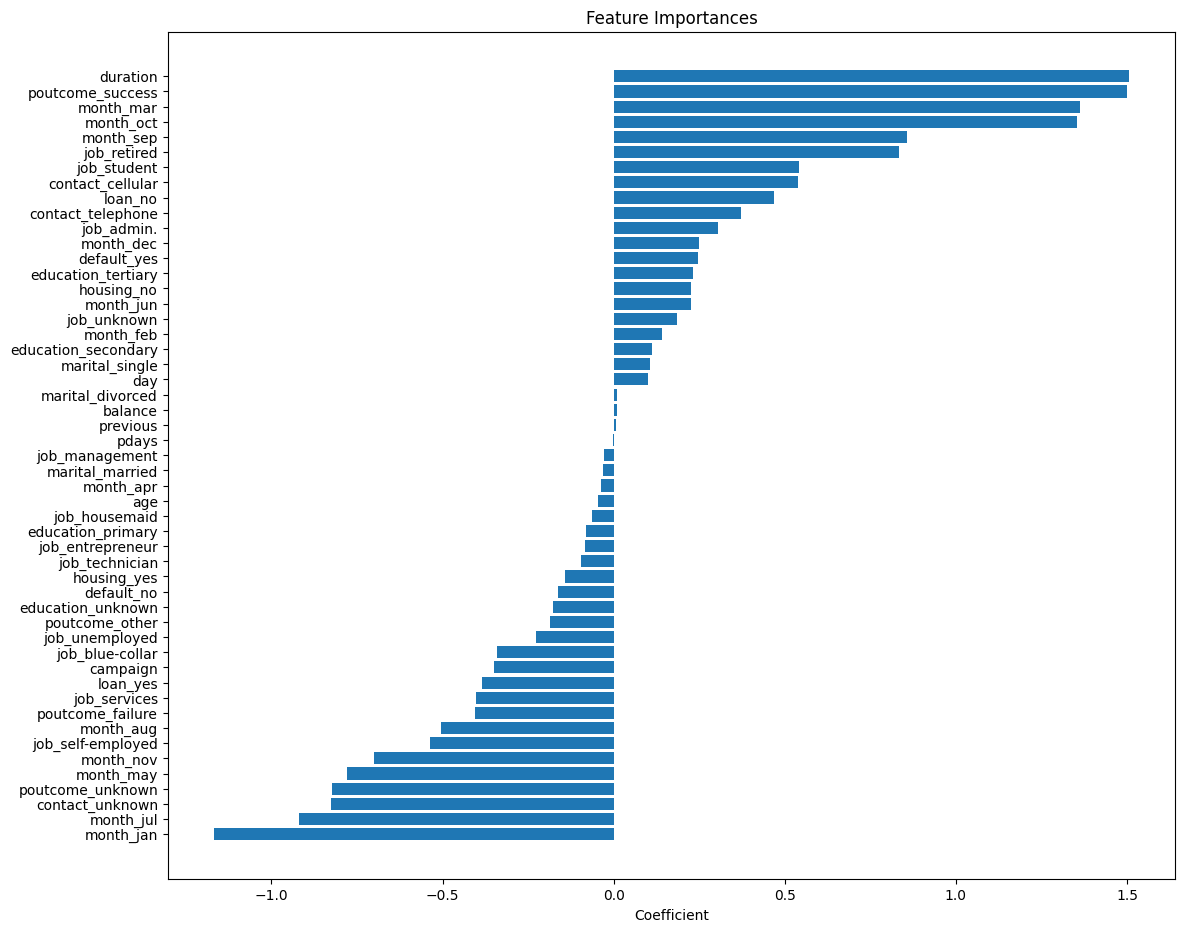

In [19]:
feature_names = (
    num_features +
    list(log_regCV.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names_out())
)

coefficients = log_regCV.named_steps['logisticregressioncv'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(13, 11))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Как мы и получали ранее, это признаки duration, poutcome, month, также job заметно влияет на результат. Попробуем теперь воспользоваться методом ближайших соседей.

##### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
param_grid = {'knn__n_neighbors': np.arange(1, 50),'knn__weights': ['uniform', 'distance'],'knn__metric': ['minkowski', 'manhattan']}
Neigh = imbpipeline([('preprocessor', preprocessor),  ('smote', SMOTE(random_state=13)),('knn', KNeighborsClassifier())])
knn_grid_search = GridSearchCV(Neigh, param_grid, cv=StratifiedKFold(5), scoring='f1')
knn_grid_search.fit(X_train,y_train)
print("Optimal parameters found:")
print(knn_grid_search.best_params_)
print(classification_report(knn_grid_search.predict(X_test),y_test,target_names = ['no','yes']))

Optimal parameters found:
{'knn__metric': 'manhattan', 'knn__n_neighbors': 30, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

          no       0.86      0.96      0.91       719
         yes       0.70      0.39      0.50       186

    accuracy                           0.84       905
   macro avg       0.78      0.67      0.70       905
weighted avg       0.83      0.84      0.82       905



Получили результаты сравнимые с логистической регрессией. В этом случае использовался SMOTE для процедуры oversampling, чтобы бороться с несбалансироанными классами. 

##### Decision Tree

Воспользуемся решающим деревом для классификации. Будем опять использовать SMOTE для работы с несбалансированными классами. 

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
param_grid = {
    'tree__criterion': ["gini", "entropy", "log_loss"],
    'tree__max_depth': np.arange(1, 20),
    'tree__min_samples_split': np.arange(2, 5),
    'tree__min_samples_leaf': np.arange(1, 3)
}
tree_class = imbpipeline([('preprocessor',preprocessor), ('SMOTE',SMOTE(random_state = 13)),('tree',DecisionTreeClassifier())])
grid_search = GridSearchCV(tree_class, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Optimal parameters found:")
print(grid_search.best_params_)
print(classification_report(grid_search.predict(X_test),y_test,target_names = ['no','yes']))

Optimal parameters found:
{'tree__criterion': 'entropy', 'tree__max_depth': 6, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 2}
              precision    recall  f1-score   support

          no       0.78      0.97      0.86       642
         yes       0.80      0.32      0.45       263

    accuracy                           0.78       905
   macro avg       0.79      0.64      0.66       905
weighted avg       0.78      0.78      0.74       905



Опять получаем, что модель имеет слишком большое количество ложнооотрицательных исходов. Посмотрим, какие признаки оказывает наибольшее влияние на принятие решения:

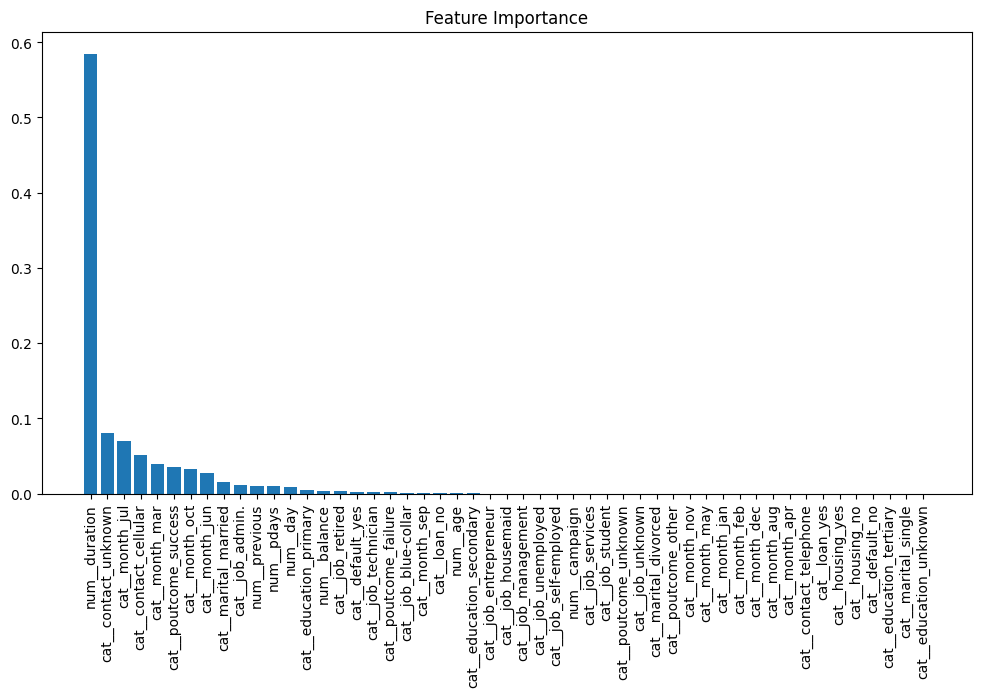

In [25]:
feature_importances = grid_search.best_estimator_.named_steps['tree'].feature_importances_
indices = np.argsort(feature_importances)[::-1]
final_feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(len(final_feature_names)), feature_importances[indices], align="center")
plt.xticks(range(len(final_feature_names)), np.array(final_feature_names)[indices], rotation=90)
plt.show()

Попробуем избавиться от нескольких незначительных признаков.

In [26]:
data_corrected = data_encoded.copy()
data_corrected.drop(['job','housing'],axis = 1)
cat_features_upd = ['education','marital','contact','month','poutcome','default','loan']
num_features_upd = ['age','balance','day','pdays','duration','previous','campaign']
X_train_upd, X_test_upd, y_train_upd, y_test_upd = train_test_split(data_corrected,np.ravel(y),train_size = 0.8, stratify = y,random_state = 13)
preprocessor_upd = ColumnTransformer( transformers=[ ('num', StandardScaler(), num_features_upd),  ('cat', OneHotEncoder(), cat_features_upd)])

In [27]:
param_grid = {
    'tree__criterion': ["gini", "entropy", "log_loss"],
    'tree__max_depth': np.arange(1, 20),
    'tree__min_samples_split': np.arange(2, 5),
    'tree__min_samples_leaf': np.arange(1, 3)
}
tree_class = imbpipeline([('preprocessor',preprocessor_upd), ('SMOTE',SMOTE(random_state = 13)),('tree',DecisionTreeClassifier())])
grid_search = GridSearchCV(tree_class, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_upd, y_train_upd)
print("Optimal parameters found:")
print(grid_search.best_params_)
print(classification_report(grid_search.predict(X_test_upd),y_test_upd,target_names = ['no','yes']))

Optimal parameters found:
{'tree__criterion': 'gini', 'tree__max_depth': 5, 'tree__min_samples_leaf': 1, 'tree__min_samples_split': 3}
              precision    recall  f1-score   support

          no       0.82      0.96      0.89       679
         yes       0.77      0.35      0.48       226

    accuracy                           0.81       905
   macro avg       0.79      0.66      0.68       905
weighted avg       0.81      0.81      0.79       905



Видим улучшение параметров recall и precision для класса yes  

### Composition of algorithms

##### Random Forest 

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
param_grid = {
    'forest__n_estimators': np.arange(100,400,25),
    'forest__min_samples_split': [2,5,10]
}
forest_pipeline = imbpipeline([
    ('preprocessor', preprocessor),  
    ('SMOTE',SMOTE(random_state = 13)),
    ('forest', RandomForestClassifier(random_state=13))  
])
grid_search_forest = GridSearchCV(forest_pipeline, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_forest.fit(X_train, y_train)
print("Optimal parameters found for RandomForest:")
print(grid_search_forest.best_params_)
y_pred_forest = grid_search_forest.predict(X_test)
print(classification_report(y_test, y_pred_forest, target_names=['no', 'yes']))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimal parameters found for RandomForest:
{'forest__min_samples_split': 5, 'forest__n_estimators': 300}
              precision    recall  f1-score   support

          no       0.93      0.96      0.94       801
         yes       0.58      0.45      0.51       104

    accuracy                           0.90       905
   macro avg       0.76      0.70      0.73       905
weighted avg       0.89      0.90      0.89       905



Использование случайного леса действительно немного улучшает accuracy и увеличивает recall вместе с f1-score. Попробуем теперь использовать не все признаки, как мы делали в предыдущем пункте:

In [30]:
param_grid = {
    'forest__n_estimators': np.arange(100,400,25),
    'forest__min_samples_split': [2,5,10]
}
forest_pipeline = imbpipeline([
    ('preprocessor', preprocessor_upd),  
    ('SMOTE',SMOTE(random_state = 13)),
    ('forest', RandomForestClassifier(random_state=13))  
])
grid_search_forest_upd = GridSearchCV(forest_pipeline, param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_forest_upd.fit(X_train_upd, y_train_upd)
print("Optimal parameters found for RandomForest:")
print(grid_search_forest_upd.best_params_)
y_pred_forest_upd = grid_search_forest_upd.predict(X_test_upd)
print(classification_report(y_test_upd, y_pred_forest_upd, target_names=['no', 'yes']))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimal parameters found for RandomForest:
{'forest__min_samples_split': 5, 'forest__n_estimators': 350}
              precision    recall  f1-score   support

          no       0.94      0.95      0.94       801
         yes       0.57      0.52      0.55       104

    accuracy                           0.90       905
   macro avg       0.76      0.73      0.74       905
weighted avg       0.90      0.90      0.90       905



Опять видим некоторое улучшение предсказательной способности алгоритма. 

##### Gradient Boosting 

In [31]:
import xgboost as xgb

In [32]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

xgb_pipeline =  imbpipeline([
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=13)),
    ('xgb', xgb_model)
])

param_grid_xgb = {
    'xgb__n_estimators': np.arange(10,100,15),
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1,0.5],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
print("Optimal parameters found:")
print(grid_search_xgb.best_params_)
y_pred = grid_search_xgb.predict(X_test)
print(classification_report(y_pred, y_test, target_names=['no', 'yes']))

C:\Users\Andrei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:58:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimal parameters found:
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.5, 'xgb__max_depth': 4, 'xgb__n_estimators': 85, 'xgb__subsample': 0.8}
              precision    recall  f1-score   support

          no       0.95      0.94      0.94       812
         yes       0.51      0.57      0.54        93

    accuracy                           0.90       905
   macro avg       0.73      0.75      0.74       905
weighted avg       0.90      0.90      0.90       905



Несмотря на то, что во время анализа данных, мы видели, что все признаки были плохо скореллированы с целевой переменной, с помощью композиции алгоритмов мы смогли уменьшить количество ложноотрицательных исходов нашего предскания и добиться accuracy = 0.9. Случайный лес и градиентный бустинг показали примерно одинаковые точности предсказаний. 